# British Airways
- Web scraping to gain company insights: This first task is focused on scraping and collecting customer feedback and reviewing data from a third-party source and analysing this data to present any insights you may uncover.
- Scrape data from the web: The first thing to do will be to scrape review data from the web. For this, you should use a website called __Skytrax__. The team leader wants you to focus on __reviews specifically about the airline itself__. You should collect as much data as you can in order to improve the output of your analysis. 

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## retrieve data from the web

In [2]:
def extract_table_info(article):
    """
    Extract info from rating table into a dict, where keys are categories
    and values is the rating for that category
    """
    table = article.find('table')
    table_dict = {}
    for row in table.find_all('tr'):
        star_fills = row.find_all('span', class_="star fill")
        star_fills_lst = [int(star_fill.text) for star_fill in star_fills] # list of nrs. indicating filled stars
        if len(star_fills_lst) == 0:
            table_dict[row.find_all('td')[0].text] = row.find_all('td')[1].text
        if len(star_fills_lst) > 0:
            review_rating = max(star_fills_lst)
            table_dict[row.td.text + '_rating'] = review_rating
    return table_dict    

In [3]:
titles_lst = []
reviews_lst = []
table_info_lst = []


# define nr. of reviews that will be shown within single page
reviews_per_pg = 10#100
nr_pages = 1#5 # define nr.pages to be read TODO make it 10

# using python requests to get web page
for page_nr in range(1, nr_pages + 1):
    # get url of each of each page (pages 1 through nr_pages) containing reviews_per_pg
    base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
    url = f"{base_url}/page/{page_nr}/?sortby=post_date%3ADesc&pagesize={reviews_per_pg}"
    r = requests.get(url)
    
    # parse content (learn more abt content and parse)
    content = r.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    # The reviews' content is stored under div, class=text_content. Find all divs with class=text_content to get content of
    # all reviews
    for review in parsed_content.find_all('div', class_="body"):
        #print(review)
        titles_lst.append(review.find('h2', 'text_header').text) # review title
        reviews_lst.append(review.find('div', 'text_content').text)# review body
        table_info_lst.append(extract_table_info(review))
        nr_reviews = len(reviews_lst)
        if nr_reviews % 2 == 0: # only print every 100 retrieved reviews
            print(f"nr. of retrieved reviews\n---->> {nr_reviews}")

print(titles_lst, '\n')
print(reviews_lst, '\n')
print(table_info_lst)

nr. of retrieved reviews
---->> 2
nr. of retrieved reviews
---->> 4
nr. of retrieved reviews
---->> 6
nr. of retrieved reviews
---->> 8
nr. of retrieved reviews
---->> 10
['"This flight was so disappointing"', '"just an average airline"', '"Luggage is delayed" ', '"the worst business class experience I\'ve ever had"', '"not recommended for business class"', '"surprisingly a good product"', '"Maybe the old charm will return soon"', '"having to pay to reserve a specific seat"', '"Upgrade was worth it"', '"Disappointing meal"'] 

['✅ Trip Verified |  Flew ATL to LHR 8th Jan 2023. Was unlucky enough to be on board a 23 year old 777. Refit gave it a decent IFE screen and the seat looked decent. Although combine the IFE with the cheap and nasty earbuds, and any movie can be ruined. Headrest was great, just a pity little padding is used on the seat as my Wife and I were very uncomfortable. The leg room in general is poor, especially when passengers keep their seat reclined from start to finis

## Store data

In [4]:
df = pd.DataFrame()
df['titles'] = titles_lst
df['reviews'] = reviews_lst
df['table_info'] = table_info_lst

df.head()

,titles,reviews,table_info
0,"""This flight was so disappointing""",✅ Trip Verified | Flew ATL to LHR 8th Jan 202...,"{'Aircraft': 'Boeing 777-200', 'Type Of Travel..."
1,"""just an average airline""",Not Verified | Great thing about British Airw...,"{'Aircraft': 'A380', 'Type Of Traveller': 'Fam..."
2,"""Luggage is delayed""",Not Verified | The staff are friendly. The pla...,"{'Type Of Traveller': 'Family Leisure', 'Seat ..."
3,"""the worst business class experience I've ever...",✅ Trip Verified | Probably the worst business ...,"{'Aircraft': 'A320, A380', 'Type Of Traveller'..."
4,"""not recommended for business class""","✅ Trip Verified | Definitely not recommended, ...","{'Type Of Traveller': 'Business', 'Seat Type':..."


In [5]:
df.to_csv('baReviews.csv', index=False)

# Clean Dataset

In [2]:
df = pd.read_csv('baReviews.csv')
df.sample(5)

,titles,reviews,table_info
7,"""having to pay to reserve a specific seat""",Not Verified | When will BA update their Busi...,"{'Aircraft': 'Boeing 777', 'Type Of Traveller'..."
3,"""the worst business class experience I've ever...",✅ Trip Verified | Probably the worst business ...,"{'Aircraft': 'A320, A380', 'Type Of Traveller'..."
8,"""Upgrade was worth it""",✅ Trip Verified | Paid £200 day before flight...,"{'Aircraft': 'Boeing 777', 'Type Of Traveller'..."
1,"""just an average airline""",Not Verified | Great thing about British Airw...,"{'Aircraft': 'A380', 'Type Of Traveller': 'Fam..."
9,"""Disappointing meal""",✅ Trip Verified | BA website did not work (we...,"{'Aircraft': 'A350', 'Type Of Traveller': 'Sol..."


In [3]:
df.dtypes

titles        object
reviews       object
table_info    object
dtype: object

In [4]:
for c in df.columns[df.dtypes=='float64']:
    print(df[c].unique())
# float64 due to missing values

In [5]:
# remove verified and not verified
df[['trip_verified','reviews']] = df['reviews'].str.split('|',expand=True)
df.head()

,titles,reviews,table_info,trip_verified
0,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,"{'Aircraft': 'Boeing 777-200', 'Type Of Travel...",✅ Trip Verified
1,"""just an average airline""",Great thing about British Airways A380 is th...,"{'Aircraft': 'A380', 'Type Of Traveller': 'Fam...",Not Verified
2,"""Luggage is delayed""","The staff are friendly. The plane was cold, w...","{'Type Of Traveller': 'Family Leisure', 'Seat ...",Not Verified
3,"""the worst business class experience I've ever...",Probably the worst business class experience ...,"{'Aircraft': 'A320, A380', 'Type Of Traveller'...",✅ Trip Verified
4,"""not recommended for business class""","Definitely not recommended, especially for bu...","{'Type Of Traveller': 'Business', 'Seat Type':...",✅ Trip Verified


In [6]:
# transform table_info column back to dict. Became text when read the csv
df['table_info'] = df['table_info'].map(eval)

In [7]:
# extract table info into cols
df = pd.concat([df, df['table_info'].apply(pd.Series)], axis=1).drop(columns=['table_info'])
df.head()

,titles,reviews,trip_verified,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort_rating,Cabin Staff Service_rating,Food & Beverages_rating,Inflight Entertainment_rating,Ground Service_rating,Value For Money_rating,Recommended,Wifi & Connectivity_rating
0,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,✅ Trip Verified,Boeing 777-200,Family Leisure,Economy Class,Atlanta to London,January 2023,1,1,1,3.0,1,2,no,NaN
1,"""just an average airline""",Great thing about British Airways A380 is th...,Not Verified,A380,Family Leisure,Economy Class,London to Chicago,December 2022,3,2,3,4.0,3,2,no,NaN
2,"""Luggage is delayed""","The staff are friendly. The plane was cold, w...",Not Verified,NaN,Family Leisure,Economy Class,Istanbul to Vancouver via Heathrow,January 2023,1,5,1,1.0,1,1,no,NaN
3,"""the worst business class experience I've ever...",Probably the worst business class experience ...,✅ Trip Verified,"A320, A380",Family Leisure,Business Class,Vienna to Los Angeles via London Heathrow,January 2023,1,2,1,1.0,1,1,no,1.0
4,"""not recommended for business class""","Definitely not recommended, especially for bu...",✅ Trip Verified,NaN,Business,Business Class,London to San francisco,January 2023,2,5,2,1.0,2,1,no,1.0


In [8]:
# lowercase words
df.columns = df.columns.str.lower()
# remove spaces and &
df.columns = df.columns.str.replace('& ', '').str.replace(' ', '_')
df.columns

Index(['titles', 'reviews', 'trip_verified', 'aircraft', 'type_of_traveller',
       'seat_type', 'route', 'date_flown', 'seat_comfort_rating',
       'cabin_staff_service_rating', 'food_beverages_rating',
       'inflight_entertainment_rating', 'ground_service_rating',
       'value_for_money_rating', 'recommended', 'wifi_connectivity_rating'],
      dtype='object')

In [9]:
df.head()

,titles,reviews,trip_verified,aircraft,type_of_traveller,seat_type,route,date_flown,seat_comfort_rating,cabin_staff_service_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,value_for_money_rating,recommended,wifi_connectivity_rating
0,"""This flight was so disappointing""",Flew ATL to LHR 8th Jan 2023. Was unlucky en...,✅ Trip Verified,Boeing 777-200,Family Leisure,Economy Class,Atlanta to London,January 2023,1,1,1,3.0,1,2,no,NaN
1,"""just an average airline""",Great thing about British Airways A380 is th...,Not Verified,A380,Family Leisure,Economy Class,London to Chicago,December 2022,3,2,3,4.0,3,2,no,NaN
2,"""Luggage is delayed""","The staff are friendly. The plane was cold, w...",Not Verified,NaN,Family Leisure,Economy Class,Istanbul to Vancouver via Heathrow,January 2023,1,5,1,1.0,1,1,no,NaN
3,"""the worst business class experience I've ever...",Probably the worst business class experience ...,✅ Trip Verified,"A320, A380",Family Leisure,Business Class,Vienna to Los Angeles via London Heathrow,January 2023,1,2,1,1.0,1,1,no,1.0
4,"""not recommended for business class""","Definitely not recommended, especially for bu...",✅ Trip Verified,NaN,Business,Business Class,London to San francisco,January 2023,2,5,2,1.0,2,1,no,1.0


In [10]:
# TODO still need to remove \r\n, start and end spaces..

for c in df.columns[df.dtypes=='object']:
    df[c] = df[c].str.lower()
    # remove ticks
    df[c] = df[c].str.replace('\W\s', '', regex=True)
    # remove double quotes from strings in column titles
    df[c] = df[c].str.replace('"', '')
df.head()

,titles,reviews,trip_verified,aircraft,type_of_traveller,seat_type,route,date_flown,seat_comfort_rating,cabin_staff_service_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,value_for_money_rating,recommended,wifi_connectivity_rating
0,this flight was so disappointing,flew atl to lhr 8th jan 2023was unlucky enough...,trip verified,boeing 777-200,family leisure,economy class,atlanta to london,january 2023,1,1,1,3.0,1,2,no,NaN
1,just an average airline,great thing about british airways a380 is the ...,not verified,a380,family leisure,economy class,london to chicago,december 2022,3,2,3,4.0,3,2,no,NaN
2,luggage is delayed,the staff are friendlythe plane was coldwe we...,not verified,NaN,family leisure,economy class,istanbul to vancouver via heathrow,january 2023,1,5,1,1.0,1,1,no,NaN
3,the worst business class experience i've ever had,probably the worst business class experience ...,trip verified,a320a380,family leisure,business class,vienna to los angeles via london heathrow,january 2023,1,2,1,1.0,1,1,no,1.0
4,not recommended for business class,definitely not recommendedespecially for busi...,trip verified,NaN,business,business class,london to san francisco,january 2023,2,5,2,1.0,2,1,no,1.0


In [11]:
df.loc[5]['reviews']

'ba shuttle service across the uk is still surprisingly a good productwhen compared with ba long haul that doesn’t always get the best of comments at timesit’s reasonable pricedworks wellfresh crews and no queues or long distances to walki don’t know why they still offer a covid style bottle of water and snack when just stretching to a cup of tea and snack would be great add on for this servicecurrently they have an on line sky cafe but it’s too fiddly to work or get connected in short trips.'

In [12]:
df['reviews'].values[0]

'flew atl to lhr 8th jan 2023was unlucky enough to be on board a 23 year old 777refit gave it a decent ife screen and the seat looked decentalthough combine the ife with the cheap and nasty earbudsand any movie can be ruinedheadrest was greatjust a pity little padding is used on the seat as my wife and i were very uncomfortablethe leg room in general is poorespecially when passengers keep their seat reclined from start to finishzero roomaircraft was tiredrubber spacers falling outsilicone sealer falling apart in the toiletstoilet seats oldstainedrubber on arm rest was hanging offno post take off drinks/snacks offered meal was sent out after a couple of hourswas poorchicken cubes that reminded me of dog foodmashed potatoes that were purified within an inch of their lifestale rock hard rollsalad which was rice and carrots?dried crackers with no cheesekids meal was just as sadtiny leaf salad with enough dressing to refloat a shipwreckcoffee creamer was given with the kids mealsnack was de

# Perform Analysis
- uncover some insights. As a starting point, you could look at topic modelling, sentiment analysis or wordclouds to provide some insight into the content of the reviews
- As a data scientist at BA, it will be your job to apply your analytical skills to influence real life multi-million-pound decisions from day one, making a tangible impact on the business as your recommendations, tools and models drive key business decisions, reduce costs and increase revenue. Customers who book a flight with BA will experience many interaction points with the BA brand. Understanding a customer's feelings, needs, and feedback is crucial for any business, including BA.

In [13]:
df.shape

(10, 16)

Could do EDA
- e.g.: can I get the scores? and if so how many times each score appears?

,seat_comfort_rating,cabin_staff_service_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,value_for_money_rating,wifi_connectivity_rating
0,1,1,1,3.0,1,2,NaN
1,3,2,3,4.0,3,2,NaN
2,1,5,1,1.0,1,1,NaN
3,1,2,1,1.0,1,1,1.0
4,2,5,2,1.0,2,1,1.0
5,4,5,3,NaN,5,4,NaN
6,5,3,1,1.0,5,4,NaN
7,3,4,4,2.0,4,3,NaN
8,3,4,4,2.0,2,3,NaN
9,4,3,2,2.0,1,2,NaN


# Review by stars

## Stars vs. categories

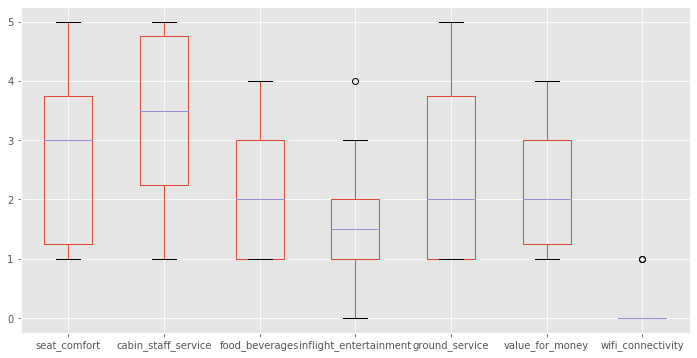

In [46]:
# average stars per category - boxplot = good overall undertsnading, bt perhaps not best
# option to present to non-technical audience. Probably better to present barplot of avg/median
df_ratings = df.select_dtypes(include=np.number)
df_ratings.columns = df_ratings.columns.str.replace('_rating', '')
df_ratings.fillna(0).plot(kind='box', figsize=(12,6))

## Sentiment Analysis w. Roberta (Hugging Face)

In [14]:
#!pip install transformers

In [18]:
!pip install torch

Keyring is skipped due to an exception: 'keyring.backends'


In [15]:
import nltk

In [16]:
from transformers import pipeline
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\thais.linsdearaujo\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\thais.linsdearaujo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

OSError: Unable to load weights from pytorch checkpoint file for 'C:\Users\thais.linsdearaujo/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\08b4d993d880171203539b37794af581debb55ca\pytorch_model.bin' at 'C:\Users\thais.linsdearaujo/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\08b4d993d880171203539b37794af581debb55ca\pytorch_model.bin'. If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True.